In this notebook we perform Bayesian optimization. A part of the code used  here is inspired from Martin Krasser's blog  on latent space Bayesian optimization https://krasserm.github.io/

we train a Gaussian process model as a surrogate for the microstructure–property relationship to enable optimization using the low-dimensional representation. The Gaussian process model is sequentially updated with samples suggested by BOpt and the corresponding mechanical property calculated from a full-field crystal plasticity model. We implement the BOpt procedure using the open-source Python library GPyOpt

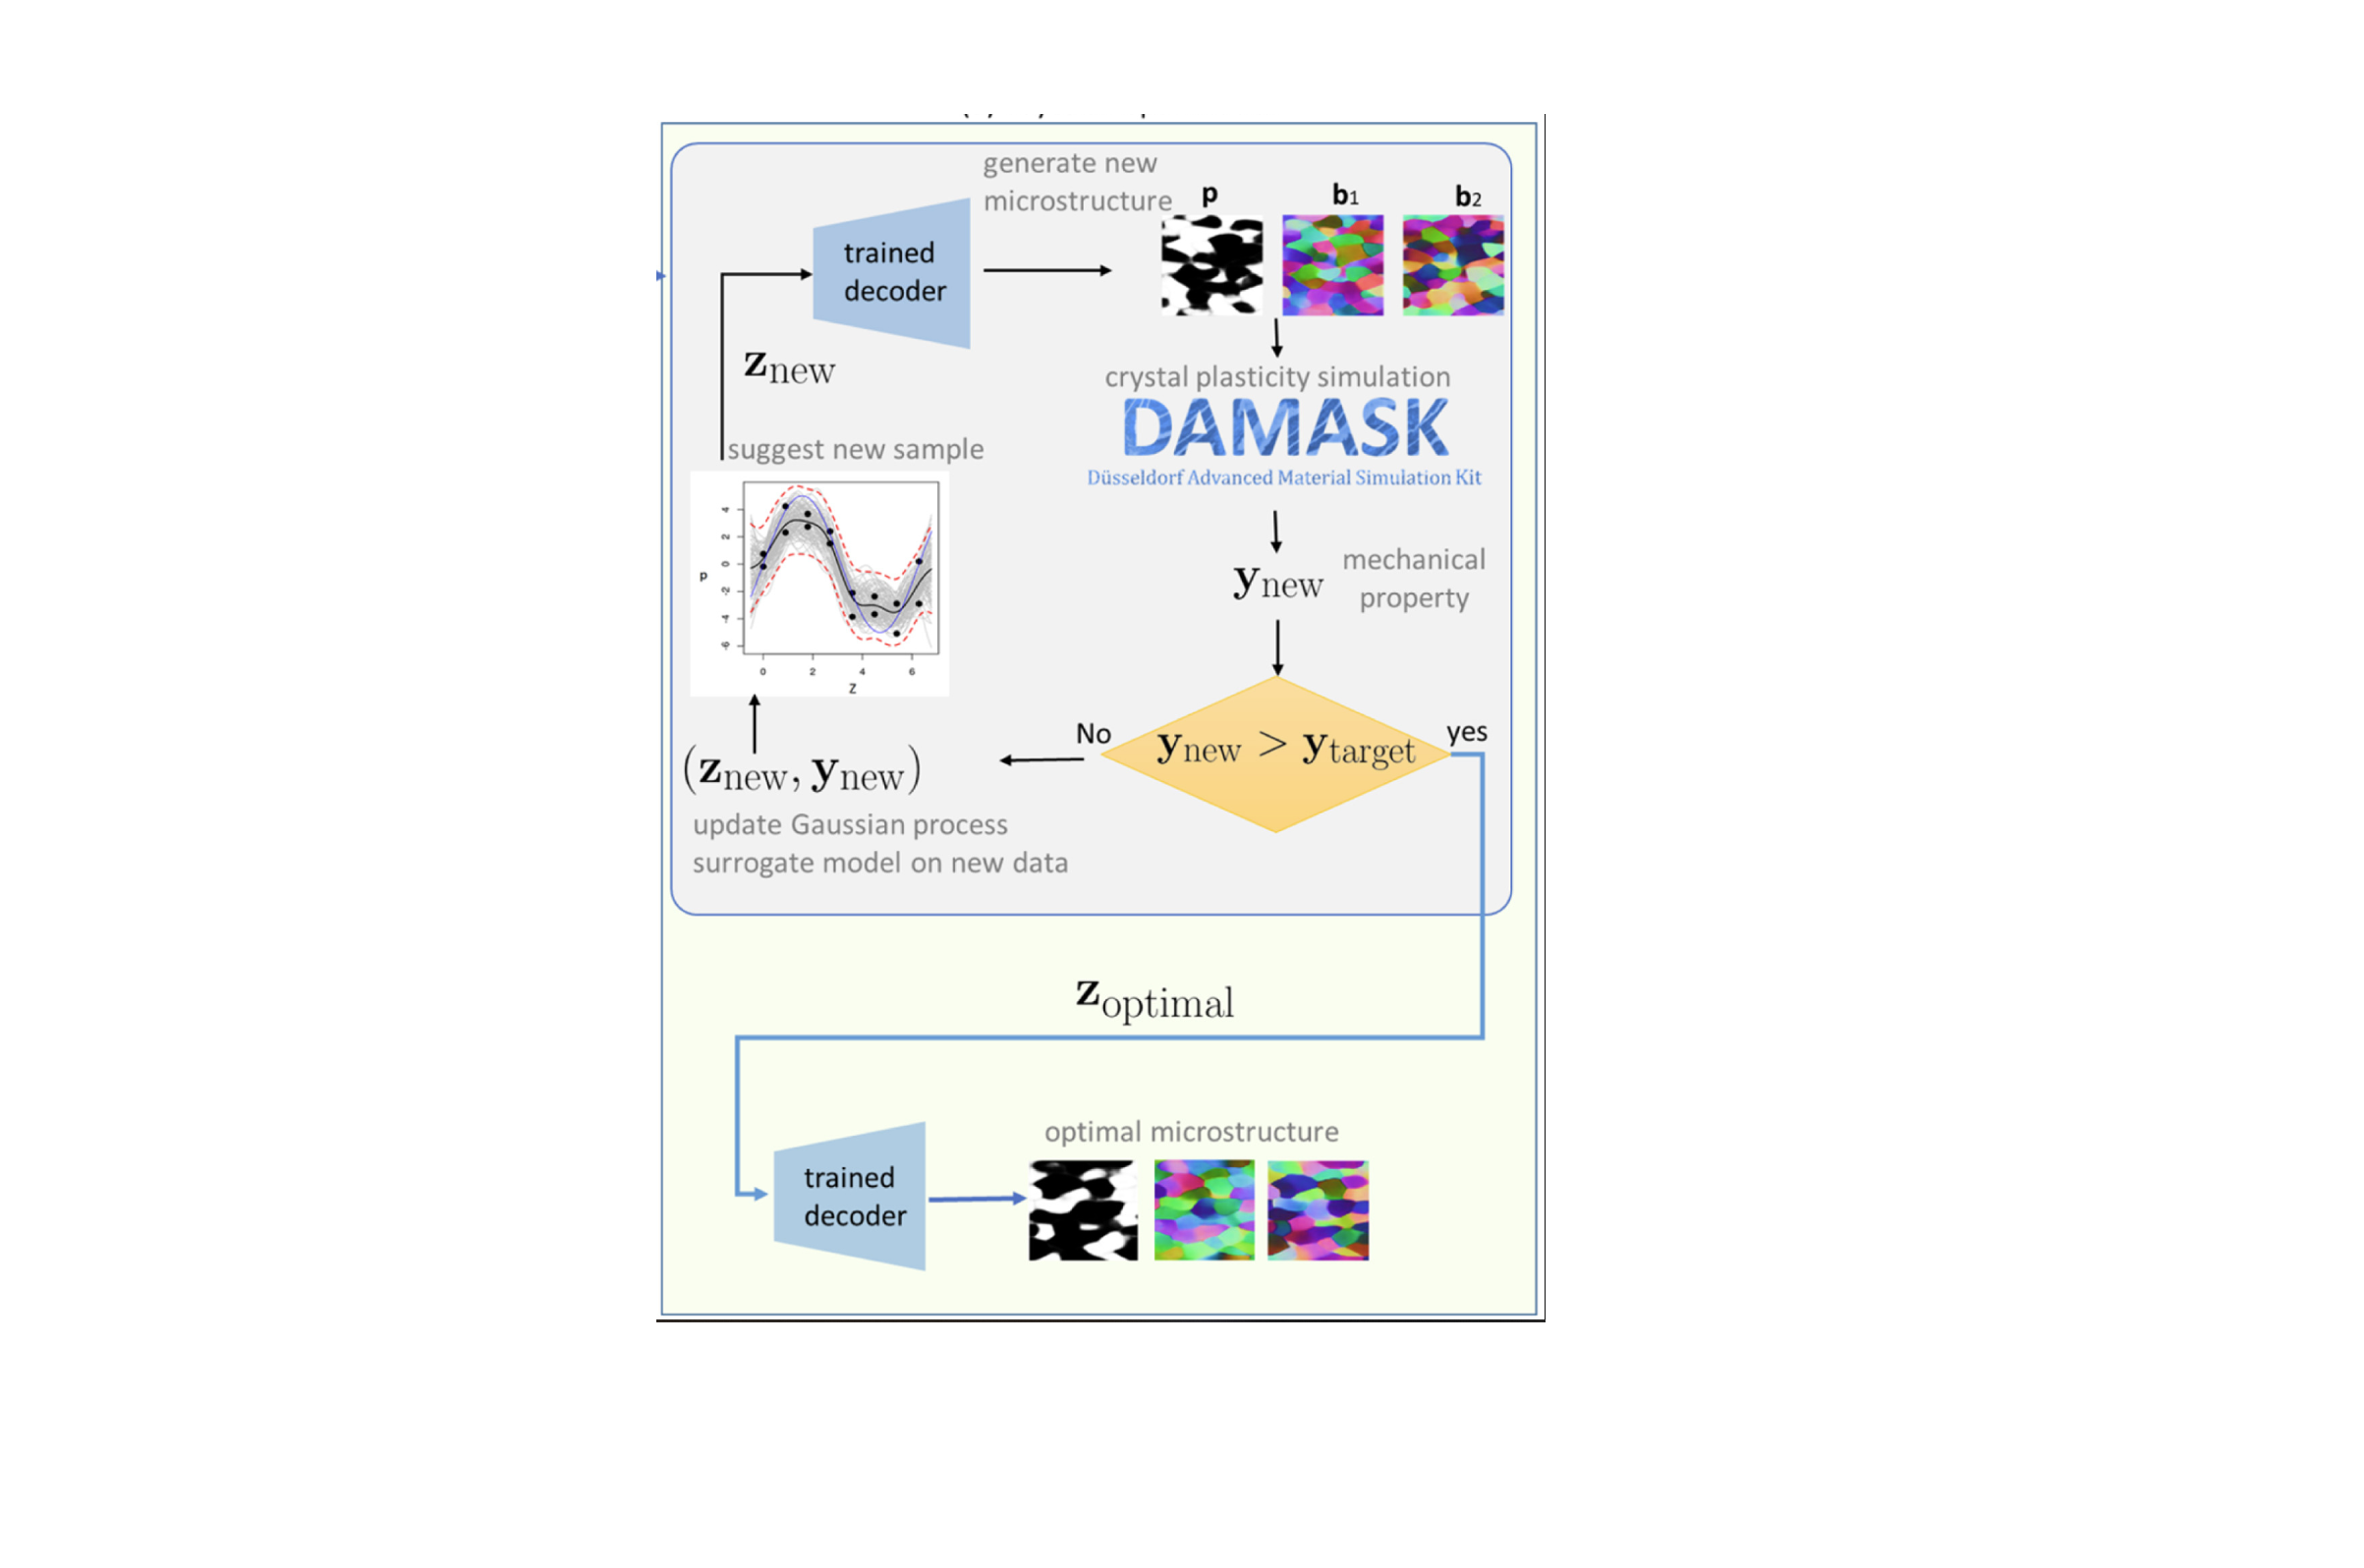

The above image shows the workflow. Bayesian optimization using latent vector $\mathbf{z}$ sampled from latent space where mechanical properties of newly generated microstructures are calculated from crystal plasticity simulations ($\mathbf{y}_\mathrm{new}$).
The optimization process identifies the low-dimensional feature vector ($\mathbf{z}_\mathrm{optimal}$) that is used to generate microstructures with the target property $\mathbf{y}_\mathrm{target}$.

Instead of sampling in the 256D latent space, we search for the optimal combination of the few latent features that influence the mechanical properties the most. In this notebook we use top 16 latent variables that the random forest model identified as features that strongly influence mechanical properties. 

The minimization objective function for 16D optimization is
\begin{equation}\label{eq:obj16D}
f(\mathbf{z}_\mathrm{16D}) = \left |\sigma_{Y}(g(\mathbf{z}_\mathrm{16D}))  -600 \right | + 3 \, d_{H}(g(\mathbf{z}_\mathrm{16D}))
\end{equation}
where $\mathbf{z}_\mathrm{16D}$ is the 16D latent vector we want to optimize and the target is to generate microstructures of yield stress \SI{600}{\mega \pascal} and low damage hotspots.

In this notebook

**Steps**

1. Import the trained VAE model
2. Import the microstructures and their mechanical responce data
    - Microstructures generated by VAE model from random sampling in latent space
    - Microstructures generated form Voronoi tessellation used in VAE training data
3.  Feature Importance analysis using Random Forest in order to select top 16 latent features that influence the mecahnical property

4. Perform Bayesian optimization 
    - we initialize the BOpt method by first selecting a random microstructure from the training data and then extracting its latent vector encoding from the VAE\_256 model.

    - We then vary 16 latent features during the BOpt process while fixing the remaining 240 latent variables. 

    - In each optimization run, the new data point $\mathbf{z}_\mathrm{16D}$ is suggested by the BOpt algorithm and we perform the crystal plasticity simulations to get the properties of the newly generated microstructure. 

In [ ]:
data_folder_name    = 'DataFolder' # select the name for the folder to save Optimization data
DAMASK_timeout         = 15*60    # time upt to stop the simulation if it doesnt converge
latent_dim             = 256      # latent dimension for VAE model
OMP_NUM_THREADS        = 12       # no of workers 
brit_damage_threshold  = 22e8    
duct_damage_threshold  = 7e7

## Utilities

### Import libraries

In [ ]:
import h5py
import damask
import sys
import os
import time
from tensorflow import keras
from scipy import interpolate, spatial
import plotly.graph_objects as go
from skimage.segmentation import quickshift, mark_boundaries
from datetime import datetime
import GPy
import GPyOpt
import pandas as pd
from scipy.stats import multivariate_normal
from statsmodels.distributions.empirical_distribution import ECDF
import seaborn as sns
import plotly.express as px
from pathlib import Path
import subprocess
import multiprocessing

sns.set_style('whitegrid')

%pylab inline
plt.rcParams.update({'font.size': 16})

In [ ]:
print("damask: ",damask.__version__)
print("keras: ",keras.__version__)
print("GPy: ",GPy.__version__)
print("GPyOpt: ",GPyOpt.__version__)

The following versions were used:

```
damask:  3.0.0-alpha5-495-g814d89532
keras:  2.11.0
GPy:  1.10.0
GPyOpt:  1.2.6
```

### Function for DAMASK simulations

In [ ]:
def plot_mic_basis(mic):
    '''
    function to plot Microstructure with Orientation as Basis vectors
    '''
    plt.figure(figsize=(30,20))
    for i in range(7):
        plt.subplot(1,9,i+1)
        plt.imshow(mic[...,i], "gray",vmin=0,vmax=1.0)
        plt.axis('off')
        plt.colorbar(fraction=0.046, pad=0.04)
    plt.subplot(1,9,8)
    plt.imshow(mic[...,1:4])
    plt.axis('off')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.subplot(1,9,9)
    plt.imshow(mic[...,4:7])
    plt.axis('off')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

In [ ]:
def plot_mic(m):
    '''
    Function to plot full microstructure
    '''
    plt.figure(figsize=(20,10))
    N = m.shape[-1]
    for i in range(N):
        plt.subplot(1,N+1,i+1)
        plt.imshow(m[...,i].reshape(128,128),'gray')
        plt.axis('off')
    plt.show()

In [ ]:
def plot_mic_hist(m):
    '''
    function to plot the histogram of microstructure data
    '''
    plt.figure(figsize=(20,4))
    N = m.shape[-1]
    for i in range(N):
        plt.subplot(1,N+1,i+1)
        plt.hist(m[...,i].ravel(),30)
    plt.show()

In [ ]:
def plot_statistics(data,name):
    '''
    statistical distribution of microstructure imnformation
    '''
    plt.figure(figsize=(15,5))
    # histogram
    plt.subplot(1,3,1)
    plt.title('histogram')
    plt.hist(data.ravel(),bins=100)
    plt.xlabel(name)
    # ecdf
    plt.subplot(1,3,2)
    ecdf = ECDF(data.ravel())
    plt.title('CDF')
    plt.plot(ecdf.x,ecdf.y)
    plt.xlabel(name)
    # box plot
    plt.subplot(1,3,3)
    plt.title('Box plot')
    sns.boxplot(x=data.ravel())
    plt.xlabel(name)
    plt.show()

In [ ]:
def plot_mic_side(m):
    m_eu = damask.Rotation.from_quaternion(m[...,1:5]).as_Euler_angles(degrees=True)
    m = np.concatenate((np.expand_dims(m[:,:,0],axis=-1),
                                 np.expand_dims(m_eu[:,:,0]/360.0,axis=-1),
                                 np.expand_dims(m_eu[:,:,1]/180.0,axis=-1),
                                 np.expand_dims(m_eu[:,:,2]/360.0,axis=-1)),axis=-1)
    plt.figure(figsize=(16,8),facecolor = 'white')
    plt.subplot(1,2,1)
    plt.imshow(m[...,0],'gray')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(m[...,1:])
    plt.axis('off')
    plt.show()

In [ ]:
def multiVoronoitessellation(img_dim,N_grains,N_mart,N_ferr):
    
    '''
    Code to generate DAMASK grid from multilevel voronoitesselation 
    
    Args**
    img_dim: grid sizer (ex: 128)
    N_grains: Total no of grains in micorstructure (ex: 100)
    N_mart: Total no of martensite grains (ex: 10)
    N_ferr: Total no of Ferrite grains (ex: 20)
    
    Returns**
    grid object 
    
    Contributer: Martin.diehl
    '''
    N_grains = N_grains

    N_mart = N_mart
    N_ferr = N_ferr

    cells_stretched = np.array([256*2,256,1])
    size_stretched  = cells_stretched.astype(float)

    cells = np.array([256,256,1])
    size = cells.astype(float)

    seeds_0 = damask.seeds.from_random(size=size_stretched, cells=cells_stretched, N_seeds = N_grains)
    seeds_1 = damask.seeds.from_random(size=size_stretched, cells=cells_stretched, N_seeds = N_mart+N_ferr)

    grid_0 = damask.Grid.from_Voronoi_tessellation(size=size_stretched,cells=cells_stretched,seeds=seeds_0)
    centers_0, _ = damask.seeds.from_grid(grid_0,average=True)

    KDTree = spatial.cKDTree(seeds_1,boxsize=size_stretched)
    _ , idx_1 = KDTree.query(centers_0)

    grid_1 = grid_0.substitute(np.arange(N_grains,dtype=int),idx_1)

    grid_1.material = np.where(grid_1.material<N_ferr,grid_1.material*-1,grid_0.material)

    grid_1 = grid_1.renumber()
    grid_1 = grid_1.scale(cells) # grid_1.scale(cells,size)
    grid_1.size = size
    
    grid_1 = grid_1.scale([128,128,1])
    grid_1.size = np.array([128,128,1]).astype(float)
    grid_1.size = grid_1.size*0.01
    return grid_1

In [ ]:
def create_microstructure_damask(img_dim,N_grains,N_mart,N_ferr):
    
    '''
    Creates material dictionary for DP steel microstructure from Multilevel voronoi tessellation
    prepares the files required to run simulation in DAMASK. 
    Args**
    img_dim: grid sizer (ex: 128)
    N_grains: Total no of micro grains (ex: 100)
    N_mart: Total no of martensite grains (ex: 10)
    N_ferr: Total no of Ferrite grains (ex: 20)
    
    Returns**
    p: binary phase array (`0` corresponds to martensite )
    o: orientation data
    
    Contributer: Navyanth.kusampudi, Sharan.Roongta
    '''
    # get multilevel voronoi tesselation grid
    grid = multiVoronoitessellation(img_dim,N_grains,N_mart,N_ferr)
    Total_grains = np.unique(grid.material.flatten()).shape[0]
    
    # initialize the material dictionsry
    material = damask.ConfigMaterial()
    
    ## 1. Add Homogenization
    # define homogenization
    hom = ['SX']*Total_grains
    # update homogenization data
    material.update({"homogenization":{"SX":{"N_constituents":1,
                                             "mechanical": {"type": "pass"}}}})
    
    ## 2. Phase distribution data
    # define phase names
    phases_list = N_ferr*['Ferrite'] + (Total_grains-N_ferr)*['Martensite']
    # extract martensite material properties
    phase_data = damask.ConfigMaterial.load('config/phase.yaml')
    # Update phase properties
    material.update({"phase": phase_data})
    
    ## 3. Orientation
    # Orientation data in quaternion for each seed
    Ori = damask.Rotation.from_random(Total_grains).as_quaternion()  # remember to give orientations only in Quaternion

    ## 4. Update and save Data for material file
    # add the data to the dictionary
    material = material.material_add(phase=phases_list,O = Ori,homogenization = hom)
    material.save()
    grid.save('my_geom')
    
    #*********** extract Phase and orientation arrays*************************
    ## extract Phase and orientation arrays from materisl (.YAML)

    # get the arrange ments of material points in the grid
    mic_array = grid.material

    # get orientaion data as quaternions 
    ori_quat_array =np.array([material['material'][i]["constituents"][0]["O"] for i in  mic_array.ravel()])

    # convert to euler
    #ori_eulr_array = damask.Rotation.from_quaternion(ori_quat_array).as_Euler_angles(degrees=True)

    # get phase array 
    phase_names_array =np.array([material['material'][i]["constituents"][0]["phase"] for i in  mic_array.ravel()])

    # assign '0' to martensite and '1' to ferrite 
    phases_array = np.array(phase_names_array=='Ferrite', dtype="uint8")

    # reshape data
    o = ori_quat_array.reshape(img_dim,img_dim,4)
    p = phases_array.reshape(img_dim,img_dim,1)
    
    return np.concatenate((p,o),axis=-1)

In [ ]:
def mic_array_to_DAMASK_geom(mic,geom_name,data_path):
    '''
    for the given microstructure numpy array this function prepares the geometry and material file 
    needed for DAMASK simulations
    
    mic: 128x128x5  Microstructure with phase and orientation data ass quaternions
    geom_name: name of geometry file
    
    
    changes the order of microstructure to F (for DAMASK)
    '''
    #******************************************************
    #          1. Create material.yaml file 
    #*******************************************************
    # get phase and orientation data
    
    phases = np.int32(mic[:,:,0]>=0.5).reshape(-1)
    ori_qu = mic[:,:,1:5].reshape(-1,4)
    ori_qu= damask.Rotation.from_quaternion(ori_qu)
    
    # consider each pixel as single grain
    N_grains = phases.shape[0]
    # initaite matertil conufig file
    mat = damask.ConfigMaterial()
    # add homogenization
    hom = ['SX']*N_grains
    # add material points 
    mat = mat.material_add(phase=phases,O = ori_qu,homogenization = hom )
    
    ## 1. Update Homogenization
    mat['homogenization'].update({"SX":{"N_constituents":1,
                                        "mechanical": {"type": "pass"}}})

    ## 2. UPdate phase
    # extract martensite material properties
    phase_data = damask.ConfigMaterial.load('config/phase.yaml')
    # Update phase properties
    mat['phase'].update(phase_data)
    # assign martensite as 0 anf ferrite as 1
    mat = mat.material_rename_phase(mapping={0: 'Martensite',1: 'Ferrite'})
    ## 3. Save matetial.YAML file
    mat.save(data_path+'material.yaml')
    
    #******************************************************
    #          2. Create Geometry file
    #*******************************************************
    # define Grid size
    cells = [128,128,1]    
    size = np.ones(3)*1   # Physical size of the seeding domain
    # Arange material point numbers in grid
    material = np.arange(0,N_grains).reshape(cells[0],cells[1],cells[2],order='F')
    # create grid
    grid = damask.Grid(material, size)
    # save grid as '.VTI' file i.e geometry file: ML_generated.vtr
    grid.save(data_path+geom_name)   
    
    #******************************************************
    #          3. Visualize final geometry file
    #*******************************************************
    # Visulaization
    mic_array = grid.material
    # get orientaion data as quaternions 
    ori_quat_array =np.array([mat['material'][i]["constituents"][0]["O"] for i in  mic_array.ravel()])
    phase_names_array =np.array([mat['material'][i]["constituents"][0]["phase"] for i in  mic_array.ravel()])
    # assign '0' to martensite and '1' to ferrite 
    phases_array = np.array(phase_names_array=='Ferrite', dtype="uint8")
    # reshape data
    o = ori_quat_array.reshape(128,128,4,order='F')
    p = phases_array.reshape(128,128,1,order='F')
    m = np.concatenate((p,o),axis=-1)
    m.shape

    # Images
    plt.figure(figsize=(20,10))
    plt.subplot(1,5,1)
    plt.imshow(m[...,0].reshape(128,128),'gray')
    plt.axis('off')
    plt.subplot(1,5,2)
    plt.imshow(m[...,1].reshape(128,128),'gray')
    plt.axis('off')
    plt.subplot(1,5,3)
    plt.imshow(m[...,2].reshape(128,128),'gray')
    plt.axis('off')
    plt.subplot(1,5,4)
    plt.imshow(m[...,3].reshape(128,128),'gray')
    plt.axis('off')
    plt.subplot(1,5,5)
    plt.imshow(m[...,4].reshape(128,128),'gray')
    plt.axis('off')
    plt.show()

    # histogram
    plt.figure(figsize=(20,5))
    plt.subplot(1,5,1)
    plt.hist(m[...,0].ravel(),30)

    plt.subplot(1,5,2)
    plt.hist(m[...,1].ravel(),30)

    plt.subplot(1,5,3)
    plt.hist(m[...,2].ravel(),30)
    plt.subplot(1,5,4)
    plt.hist(m[...,3].ravel(),30)
    plt.subplot(1,5,5)
    plt.hist(m[...,4].ravel(),30)

    plt.show()

In [ ]:
def damask_simulations(geom_name, OMP_NUM_THREADS, config_path, data_path, timeout=DAMASK_timeout):
    """
    Runs a DAMASK simulation and waits for it to complete.

    Args:
        geom_name (str): The name of the geometry file.
        OMP_NUM_THREADS (int): The number of threads to use for the simulation.
        config_path (str): The path where the numerics and load files are stored.
        data_path (str): The path where the geometry file is stored and where the simulation data will be stored.
        timeout (float or None): The maximum amount of time to wait for the simulation to complete, in seconds.

    Returns:
        int: The exit status of the simulation (0 for success, non-zero for failure).
    """
    cmd = [
        'DAMASK_grid',
        '-w', data_path,
        '-g', '{}.vti'.format(geom_name),
        '-l', '{}/tensionX.yaml'.format(config_path),
        '-n', '{}/numerics.yaml'.format(config_path)
    ]
    
    env = dict(os.environ, OMP_NUM_THREADS=str(OMP_NUM_THREADS))

    log_file_path = '{}/{}_log_file.txt'.format(data_path, geom_name)

    with open(log_file_path, 'w') as log_file:
        with subprocess.Popen(
            cmd, 
            env=env,
            stdout=subprocess.PIPE, 
            stderr=subprocess.STDOUT, 
            universal_newlines=True
        ) as proc:
            try:
                stdout, _ = proc.communicate(timeout=timeout)
                log_file.write(stdout)
                if 'increment 230 converged' in stdout:
                    return 0
                else:
                    return proc.returncode
            except subprocess.TimeoutExpired:
                # The process has not completed within the timeout period.
                # Kill the process and return a non-zero exit code to indicate failure.
                proc.kill()
                return 1

In [ ]:
def post_processing(result_file):
    """
    It Edits the given .HDF5 file to add the Von mises stress and 
    Damage parameter values only to the increment 230
    """
    ##1. load data
    result = damask.Result(result_file)
    
    ## 2. Add data
    # add IPF
    r = result.view('increments',0)
    r.add_IPF_color(l=np.array([0,0,1]))
    
    r.view_less('increments',0)
    #Select data only from last increment
    r = result.view('increments',230)
    #add cauchy stress                              
    r.add_stress_Cauchy()                                               # sigma 
    # add von mises of cauchy Stress                 
    r.add_equivalent_Mises('sigma')                                     # sigma_vM
    # add Strain tensor                       
    r.add_strain(F='F', t='V')                                          # epsilon_V^0.0(F)
    # add Von Mises for strain
    r.add_equivalent_Mises('epsilon_V^0.0(F)')                          # epsilon_V^0.0(F)_vM
    #add plastic strain tensor
    r.add_strain(F='F_p', t='U')                                        # epsilon_U^0.0(F_p)
    # add vonvmises for plastic strain tensor
    r.add_equivalent_Mises('epsilon_U^0.0(F_p)')                        # epsilon_U^0.0(F_p)_vM
    # add hydrostatic stress 
    r.add_spherical('sigma')                                            # p_sigma 
    # add ductile damage indicator
    duc_dam_f='#epsilon_U^0.0(F_p)_vM#*0.5*(#p_sigma#+np.abs(#p_sigma#))'
    r.add_calculation(
            formula=duc_dam_f,
            name='duc_damage',
            unit='N/m^2', 
            description='Ductile Damage indicator')                    # duc_damage
    # add the brittle damage indicator 
    # (maximum principal stress - Rankie damage indicator)
    r.add_eigenvalue('sigma',eigenvalue='max')                         # lambda_max(sigma)  

In [ ]:
def extract_picolastress_P1_converged(log_file):
    """
    Extracts P11 and F11 from a DAMASK simulation log file.

    P11: First component of Piola-Kirchhoff stress (MPa).
    F11: First component of deformation gradient.

    Args:
    log_file (str): Path to the DAMASK simulation log file.

    Returns:
    tuple: Two lists containing the stress and deformation values respectively.
    """
    # Read the log file content
    with open(log_file, "r") as file:
        all_lines = file.read()

    # Define regex to find convergence data
    regex = r"(?:.*\n){43}.*converged.*"
    matches = re.finditer(regex, all_lines, re.MULTILINE)

    # Extract lines matching the convergence pattern
    new_lines = [match.group() for match in matches]

    # Extract Piola-Kirchhoff stress values
    stress = []
    for line in new_lines:
        pattern_1 = r"Piola.*\n.............."
        a = re.findall(pattern_1, line)
        pattern_2 = r"[0-9].*\....."
        b = float(re.findall(pattern_2, a[0])[0])
        stress.append(b)

    # Generate deformation gradient values
    deformation = np.round(np.concatenate((1 + np.linspace(0, 0.01, 51)[1:], 1 + np.linspace(0.01, 0.07, 181)[1:])), 7).tolist()

    return stress, deformation


In [ ]:
def yield_stress_strain(F11,P11,strain_pl,plot_graph=False):
    
    '''
    calculates the yield stress for a given stress strain data points 
    of single microstructure
    
    Args**
            1. F11: avg deformation for all load increments
            2. P11: avg first picola kirchoff stress for all increments
            3. Strain_pl: plastic strain at which the yield occurs
    
    returns**
            1. yield Stress corresponding to the given plastic strain
            2. strain at yield stress
            
            Steps

            1. Get the discrete stress strain data points of a single microstructure
            2. Fit the stress strain points to a curve using the univarientSpline
            3. Take linear samples of strain ($\varepsilon_{re}$) and get the corresponding
                fitting values of stress ($\sigma_{re}$)
            4. define the plastic strain at which the yielding occurs ($\varepsilon_{pl}$)
            5. we need to look for the first point in the list where the following value 
            is positive,the stress at the corresponding point is yield stress

              $$ (\varepsilon_{re}-\varepsilon_{pl})*E-\sigma_{re} $$

              $$ \sigma_{yield} = \sigma(where ( (\varepsilon_{re}-\varepsilon_{pl})*E-\sigma_{re} )> 0 )$$
            
    '''
    
    strain = np.array(F11) - 1.0
    stress = P11
    E = stress[1]/strain[1] # stiffness
    strain_pl = strain_pl       # plastic strain
    #### curve fitting with spline
      # sorting the strain and stress values (problem due to cutback)
    stress_strain_spl = interpolate.UnivariateSpline(strain[1:], stress[1:],s=50)   # ignore the first data point 
    strain_re = np.linspace(strain[0],strain[-1],1000)                              #  linear sampled new strain 
    stress_re = stress_strain_spl(strain_re)                                      # get sampled stress

    # get yield stress 
    yield_stress_idx = np.argmax(((strain_re-strain_pl)*E - stress_re)>0)    # first point where he value is poisitive
    yield_Stress     = stress_re[yield_stress_idx]
    strain_at_yield  = strain_re[yield_stress_idx]
    
    if plot_graph==True:
        """plt.figure(figsize(20,8))
        plt.scatter(strain_re, stress_re,s=1)
        plt.scatter(strain_re, (strain_re)*E,s=2)
        plt.scatter(strain_re, (strain_re-strain_pl)*E,s=3)
        plt.scatter(strain_re, ((strain_re-strain_pl)*E - stress_re),s=4,c="y")
        plt.scatter(strain_at_yield,yield_Stress,s=300)
        plt.xticks(np.arange(0.0, 0.07, step=0.002))
        plt.yticks(np.arange(0.0, 1400, step=50.0))
        plt.ylim(bottom=0.0,top=1400)
        plt.show()"""
        
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=strain_re, y=stress_re,
            name='stress_re',
            mode='markers',
            marker_color='rgba(0, 0, 0, .8)'
        ))
        fig.add_trace(go.Scatter(
            x=strain_re, y=(strain_re)*E,
            name='(strain_re)*E',
            marker_color='rgba(255, 255, 0, .9)'
        ))
        fig.add_trace(go.Scatter(
            x=strain_re, y=(strain_re-strain_pl)*E,
            name='(strain_re-strain_pl)*E',
            marker_color='rgba(0, 255, 255, .9)'
        ))
        fig.add_trace(go.Scatter(
            x=strain_re, y=((strain_re-strain_pl)*E - stress_re),
            name='((strain_re-strain_pl)*E - stress_re)',
            marker_color='rgba(0, 0, 193, .9)'
        ))

        fig.add_trace(go.Scatter(
            x=[strain_at_yield,strain_at_yield], y=[yield_Stress,yield_Stress],
            name='yield_Stress',
            marker_size=20.0
        ))
        
        fig.update_layout(yaxis_range=[-20,1000.0],
                         title="Loading curve",
                         xaxis_title="F11",
                         yaxis_title="P11 (Mpa)",)
        
        fig.show()
    
    return yield_Stress, strain_at_yield

In [ ]:
def extract_data(result_file,log_file):
    """
    
    """
    ## 1.Load data 
    # extract data from HDF5 file
    result = damask.Result(result_file)
    #Select data only from last increment
    r = result.view('increments',230)
    
    ## 2. Phase data
    # assign '0' to martensite and '1' to ferrite 
    phases = np.array(r.phase== 'Ferrite', dtype="uint8").reshape(128,128)
    
    ## 3. Orientation
    #Select data only from initial increment: Just to get the Initial orientation information
    r = result.view('increments',0)
    # get initial orientation of Quaternions
    O_qu = r.place()["phase"]['O'].data
    
    # set the r back to last increment for further calculations
    r = result.view('increments',230)
    
    ## 4. Yield stress
    #  Extract the stress strain data fro all increments from log file 
    P11,F11 = extract_picolastress_P1_converged(log_file)
    # get Yield stress and plot Loading curve
    yield_stress, yield_strain = yield_stress_strain(F11,P11,strain_pl=0.002,plot_graph=False)
    
    ## 6. Damage data
    brit_damage = r.place()['phase']['lambda_max(sigma)'].data
    duct_damage = r.place()['phase']['duc_damage'].data
    

    # final data
    O_qu_w = O_qu[:,0].reshape(128,128)
    O_qu_x = O_qu[:,1].reshape(128,128)
    O_qu_y = O_qu[:,2].reshape(128,128)
    O_qu_z = O_qu[:,3].reshape(128,128)
    O_qu = np.concatenate((np.expand_dims(O_qu_w,-1),
                           np.expand_dims(O_qu_x,-1),
                           np.expand_dims(O_qu_y,-1),
                           np.expand_dims(O_qu_z,-1)
                            ),-1)
    
   
    brit_damage = brit_damage.reshape(128,128)
    duct_damage = duct_damage.reshape(128,128)
  
    return phases,O_qu,F11,P11,brit_damage,duct_damage,yield_stress,yield_strain

In [ ]:
def Visualize_results(phases, O_qu,O_eu,F11,P11, VM_stress,VM_strain,brit_damage,duct_damage,yield_stress,yield_strain,IPF)  :
    """
    Visualize all data
    1. Microstructure
    2. Loading curve
    3. MEchanical responce
    """
    # plot orientations: Quternion
    plt.figure(figsize=(20,5))
    plt.subplot(1,5,1)
    plt.title("phase")
    plt.imshow(phases.reshape(128,128),'gray')
    plt.subplot(1,5,2)
    plt.title("q_w")
    plt.imshow(O_qu[:,:,0].reshape(128,128),'gray')
    plt.subplot(1,5,3)
    plt.title("q_x")
    plt.imshow(O_qu[:,:,1].reshape(128,128),'gray')
    plt.subplot(1,5,4)
    plt.title("q_y")
    plt.imshow(O_qu[:,:,2].reshape(128,128),'gray')
    plt.subplot(1,5,5)
    plt.title("q_z")
    plt.imshow(O_qu[:,:,3].reshape(128,128),'gray')
    plt.show()
    
    # plot Yield stress and stress_strain curve
    _,_ = yield_stress_strain(F11,P11,strain_pl=0.002,plot_graph=True)
    

    # plot damage data
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.imshow(brit_damage.reshape(128,128),vmax=1e9)
    plt.title("brittle damage indicator")
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(duct_damage.reshape(128,128),vmax=1e8)
    plt.title("Duct damage indicator")
    plt.colorbar()
    plt.show()
    
    # plot IPF
    plt.imshow(IPF.reshape(128,128,3))
    plt.show()

In [ ]:
def post_processing_and_Visualization(file_path,mic_name):

    # *********************** post processing
    data_folder = file_path + mic_name +"/"
    result_file = data_folder + mic_name + "_tensionX.hdf5"
    post_processing(result_file)

    # ********************Extract data
    log_file = data_folder + mic_name +'_log_file.txt'
    phases, O_qu,F11,P11,brit_damage,duct_damage,Yld,yield_strain= extract_data(result_file,log_file)
    # **********************visualize data
    #Visualize_results(phases, O_qu,O_eu,F11,P11, VM_stress,VM_strain,brit_damage,duct_damage,Yld,yield_strain,IPF)
    
    yield_value = Yld
    duct_damage = np.float64(duct_damage)
    brit_damage = np.float64(brit_damage)
    duc_value = np.sum(np.int32(duct_damage>=1e8))/(1.28*128)
    bri_value = np.sum(np.int32(brit_damage>=1e9))/(1.28*128)
    
    # ************************plot damage
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('brittle damage indicator')
    plt.imshow(brit_damage,vmin=0.0,vmax=1e9,cmap='jet')
    plt.axis('off')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.imshow(phases,'gray',alpha=0.1)
    plt.subplot(1,2,2)
    plt.title('ductile damage indicator')
    plt.imshow(duct_damage,vmax=1e8,cmap='jet')
    plt.axis('off')
    plt.colorbar(fraction=0.046, pad=0.04)
    #plt.imshow(phases,'gray',alpha=0.1)

    
    print('mart %: ', 100-np.sum(phases)/(1.28*128))
    print("Yield stress",yield_value)
    print("Brit dam %", bri_value)
    print("Duct dam %",duc_value)
    
    return yield_value,yield_strain,bri_value,duc_value,F11,P11,duct_damage

### Functions for VAE

In [ ]:
def from_quat_to_basisVector_VAE_input(mic):
    '''
    convert the quat mic 128x128x5 to basis vector mic 128x128x7 
    and then rescale the basis vectors
    '''
    # convert quat to basis vectors
    quat = mic[...,1:5]
    matrix = damask.Rotation.from_quaternion(quat).as_matrix()
    basis_1 = matrix[...,0,:] 
    basis_2 = matrix[...,1,:]
    # convert basis vectors to range 0~1
    basis_1 = basis_1/2.0 + 0.5
    basis_2 = basis_2/2.0 + 0.5
    
    return np.concatenate((mic[...,0:1], basis_1, basis_2),-1).reshape(-1,128,128,7)

In [ ]:
def reconstruct_noisy_basis_vectors(basis_1,basis_2):
    '''
   
    bais vectors range: -1 to 1
    
    1. normalize both basis vectors
    2. Apply orthogonal condition
    '''
    b_rec_1 = basis_1.reshape(-1,3)
    b_rec_2 = basis_2.reshape(-1,3)
    
    b_1_list = []
    b_2_list = []

    for i in range(128*128):
        a_rec_1 = b_rec_1[i]
        a_rec_2 = b_rec_2[i]
        a_rec_1/= np.linalg.norm(a_rec_1)
        a_rec_2/= np.linalg.norm(a_rec_2)
        a_rec_2 -= a_rec_2.dot(a_rec_1) * a_rec_1 # make orthogonal
        b_1_list.append(a_rec_1)
        b_2_list.append(a_rec_2)
        
    basis_1 = np.array(b_1_list).reshape(128,128,3)
    basis_2 = np.array(b_2_list).reshape(128,128,3)
    
    return basis_1, basis_2

In [ ]:
def from_VAEgenerated_to_DAMASK(mic):
    '''
    convert VAE gen mic 128x128x7 to DAMASK mic 128x128x5 quat
    1. threshold for phase
    2. COnvert the basis vectors to original range
    3. Reconstruct the noisy basis vectors
    4. Convert to quaternion
    '''
    mic = np.float64(mic)
    
    # 1. threshold for phase
    phase = np.float64(mic[...,0:1]>=0.5)
    
    # 2. COnvert the basis vectors to original range
    basis_1 = mic[...,1:4]
    basis_2 = mic[...,4:7]
    basis_1 = 2.0*basis_1 - 1.0
    basis_2 = 2.0*basis_2 - 1.0
    
    # 3. Reconstruct the noisy basis vectors
    basis_1,basis_2 = reconstruct_noisy_basis_vectors(basis_1,basis_2)
    
    # 4. Convert to quaternoin 
    basis_1 = np.float64(basis_1.reshape(-1,1,3))
    basis_2 = np.float64(basis_2.reshape(-1,1,3))
    b = np.array(128*128*[[[1,0,0],[0,1,0]]])
    # reconstruct bact to quaternion rotations 
    quat= damask.Rotation.from_parallel(np.concatenate((basis_1,basis_2),axis=1).tolist(),b)
    quat =  np.array(quat).reshape(128,128,4)
    
    return np.concatenate((phase,quat),axis=-1)

In [ ]:
def encode(encoder, images):
    '''
    Encodes images with the encoder of the given trained VAE model
    args**
        images: shape nx128x128x7
    '''
    return encoder.predict([images])[0] # only mean

In [ ]:
def decode(decoder, latent_codes):
    '''
    Decodes latent vectors (codes) to an image with a given VAE model
    args*
        codes: latent vector encodings
    '''
    return decoder.predict([latent_codes])

In [ ]:
def encode_decode(encoder,decoder, images ):
    '''
    encods and decods an image with the train vae model
    '''
    return decode(decoder, encode(encoder,images))

In [ ]:
def plot_mic_basis_color(mic):
    plt.figure(figsize=(30,6))
    
    plt.subplot(1,3,1)
    plt.imshow(mic[...,0], "gray",vmin=0,vmax=1.0)
    plt.axis('off')
    plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.subplot(1,3,2)
    plt.imshow(mic[...,1:4])
    plt.axis('off')
    plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.subplot(1,3,3)
    plt.imshow(mic[...,4:7])
    plt.axis('off')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

###  Import VAE model and test it

In [ ]:
# vae_256
encoder_256 =  keras.models.load_model('VAE256_500Epochs_encoder.h5')
decoder_256=  keras.models.load_model('VAE256_500Epochs_decoder.h5')

In [ ]:
# generate new microstructure
img_dim = 128
mic_test= create_microstructure_damask(128,50,20,15)
# preprare the input for VAE
vae_input_mic = from_quat_to_basisVector_VAE_input(mic_test)
# get reconstruction from VAE
plot_mic_basis(vae_input_mic[0])
plot_mic_basis(encode_decode(encoder_256,decoder_256,vae_input_mic)[0])

## Import and analyze Data

In [ ]:
def from_prop_to_obj(yield_stress, brit_damage, duct_damage):
    """
    Calculate the objective function value based on yield stress, brittle damage hotspots, 
    and ductile damage hotspots.

    This function evaluates the objective function by considering the yield stress and the 
    percentages of brittle and ductile damage hotspots. It identifies damage hotspots based 
    on predefined thresholds and calculates their percentages. The objective function is 
    then computed as a weighted sum of the absolute difference from a target yield stress 
    and the combined damage percentages.

    Args:
        yield_stress (float): The yield stress value.
        brit_damage (ndarray): The brittle damage values.
        duct_damage (ndarray): The ductile damage values.

    Returns:
        obj (float): The calculated objective function value.
    """
    
    # Identify brittle damage hotspots based on the threshold
    bri_hotspots = brit_damage > brit_damage_threshold
    
    # Identify ductile damage hotspots based on the threshold
    duc_hotspots = duct_damage > duct_damage_threshold
    
    # Identify combined damage hotspots (either brittle or ductile)
    both_damage_hotspots = np.logical_or(bri_hotspots, duc_hotspots)

    # Calculate the percentage of brittle damage hotspots
    bri_damage_percentage = np.sum(np.int32(bri_hotspots)) / (128 * 128)
    
    # Calculate the percentage of ductile damage hotspots
    duc_damage_percentage = np.sum(np.int32(duc_hotspots)) / (128 * 128)
    
    # Calculate the percentage of combined damage hotspots
    both_damage_percentage = np.sum(np.int32(both_damage_hotspots)) / (128 * 128)

    # Calculate the objective function value
    obj = np.abs(yield_stress - 600) + 3 * both_damage_percentage
    
    # Print the yield stress and damage percentages for debugging
    print(yield_stress, bri_damage_percentage, duc_damage_percentage, both_damage_percentage)
    
    return obj

### Microstructures generated by VAE model from random sampling in latent space

#### Extract data

In [ ]:
import h5py
import numpy as np

def get_vae_2000_data(data_file):
    """
    Extracts and processes data from a DAMASK simulation HDF5 file.

    The function reads various simulation parameters and results, filters out 
    failed simulations, and returns the data for up to 2000 simulations.

    DAMASK_Status = 0   ===> good
    DAMASK_Status = 1   ===> failed

    Args:
    data_file (str): Path to the DAMASK simulation HDF5 file.

    Returns:
    tuple: Arrays containing latent vectors, yield stresses, brittle damage,
           ductile damage, and martensite content for up to 2000 simulations.
    """
    # Initialize lists to store the data
    latent_vector_all = []
    phase_all = []
    ori_quat_all = []
    brit_damage_all = []
    duct_damage_all = []
    F11_all = []
    P11_all = []
    yield_stress_all = []
    yield_strain_all = []

    # Read the HDF5 file
    with h5py.File(data_file, "r") as h5_data:
        for mic_name in h5_data.keys():
            DAMASK_status = h5_data[mic_name]["DAMASK_status"][()]
            print(f"{mic_name} status: {DAMASK_status}")
            if DAMASK_status == 0:  # If simulation successful
                latent_vector = h5_data[mic_name]["data"]["latent_vector"][:]
                phase = h5_data[mic_name]["data"]["phase"][:]
                ori_quat = h5_data[mic_name]["data"]["ori_quat"][:]
                brit_damage = h5_data[mic_name]["data"]["brit_damage"][:]
                duct_damage = h5_data[mic_name]["data"]["duct_damage"][:]
                F11 = h5_data[mic_name]["data"]["F11"][:]
                P11 = h5_data[mic_name]["data"]["P11"][:]
                yield_stress = h5_data[mic_name]["data"]["yield_stress"][()]
                yield_strain = h5_data[mic_name]["data"]["yield_strain"][()]

                # Append data to respective lists
                latent_vector_all.append(latent_vector)
                phase_all.append(phase)
                ori_quat_all.append(ori_quat)
                brit_damage_all.append(brit_damage)
                duct_damage_all.append(duct_damage)
                F11_all.append(F11)
                P11_all.append(P11)
                yield_stress_all.append(yield_stress)
                yield_strain_all.append(yield_strain)

    # Limit data to 2000 simulations
    N = 2000
    latent_vector_all = np.array(latent_vector_all)[:N]
    phase_all = np.array(phase_all)[:N]
    ori_quat_all = np.array(ori_quat_all)[:N]
    brit_damage_all = np.array(brit_damage_all)[:N]
    duct_damage_all = np.array(duct_damage_all)[:N]
    F11_all = np.array(F11_all)[:N]
    P11_all = np.array(P11_all)[:N]
    yield_stress_all = np.array(yield_stress_all)[:N]
    yield_strain_all = np.array(yield_strain_all)[:N]
    mart_all = np.array([100 - np.sum(p) / (1.28 * 128) for p in phase_all])

    return latent_vector_all, yield_stress_all, brit_damage_all, duct_damage_all, mart_all

In [ ]:
vae_2000_data_file = "latinHypercube_VAE256_500Epochs_seed9_3000_property_data_loadRD.hdf5"
vae_latentVectors, vae_yieldStress, vae_britHotspots, vae_ductHotspots,vae_mart = get_vae_2000_data(vae_2000_data_file)

In [ ]:
X_2000_vae = vae_latentVectors
Y_2000_vae = np.array([from_prop_to_obj(vae_yieldStress[i], 
                           vae_britHotspots[i], 
                           vae_ductHotspots[i]) for i in range(0,2000)])

#### Analyze data

In [ ]:
X_2000_vae.shape, Y_2000_vae.shape

In [ ]:
plot_statistics(X_2000_vae.ravel(),'latent vectors')

In [ ]:
plot_statistics(Y_2000_vae.ravel(),'objective')

In [ ]:
np.argsort(Y_2000_vae)[-10:]

In [ ]:
# look at the bad microstructues
decoded_bad_mic_vae = decoder_256.predict(X_2000_vae[np.argsort(Y_2000_vae)[-10:]])
decoded_bad_mic_vae.shape

In [ ]:
for m in decoded_bad_mic_vae:
    plot_mic_basis_color(m)

### Microstructures generated form Voronoi tessellation used in VAE training data

#### Extract data

In [ ]:
import h5py
import numpy as np

def get_voronoi_2000_data(encoder, data_file):
    """
    Extracts and processes data from a DAMASK simulation HDF5 file and generates latent vectors using a VAE encoder.

    The function reads various simulation parameters and results, filters out 
    failed simulations, and returns the data for up to 2000 simulations.

    DAMASK_Status = 0   ===> good
    DAMASK_Status = 1   ===> failed

    Args:
    encoder (Model): VAE encoder model to generate latent vectors.
    data_file (str): Path to the DAMASK simulation HDF5 file.

    Returns:
    tuple: Arrays containing latent vectors, yield stresses, brittle damage,
           ductile damage, and martensite content for up to 2000 simulations.
    """
    # Initialize lists to store the data
    phase_all = []
    ori_quat_all = []
    brit_damage_all = []
    duct_damage_all = []
    F11_all = []
    P11_all = []
    yield_stress_all = []
    yield_strain_all = []

    # Read the HDF5 file
    with h5py.File(data_file, "r") as h5_data:
        for mic_name in h5_data.keys():
            DAMASK_status = h5_data[mic_name]["DAMASK_status"][()]
            print(f"{mic_name} status: {DAMASK_status}")
            if DAMASK_status == 0:  # If simulation successful
                phase = h5_data[mic_name]["data"]["phase"][:]
                ori_quat = h5_data[mic_name]["data"]["ori_quat"][:]
                brit_damage = h5_data[mic_name]["data"]["brit_damage"][:]
                duct_damage = h5_data[mic_name]["data"]["duct_damage"][:]
                F11 = h5_data[mic_name]["data"]["F11"][:]
                P11 = h5_data[mic_name]["data"]["P11"][:]
                yield_stress = h5_data[mic_name]["data"]["yield_stress"][()]
                yield_strain = h5_data[mic_name]["data"]["yield_strain"][()]

                # Append data to respective lists
                phase_all.append(phase)
                ori_quat_all.append(ori_quat)
                brit_damage_all.append(brit_damage)
                duct_damage_all.append(duct_damage)
                F11_all.append(F11)
                P11_all.append(P11)
                yield_stress_all.append(yield_stress)
                yield_strain_all.append(yield_strain)

    # Limit data to 2000 simulations
    N = 2000
    phase_all = np.array(phase_all)[:N]
    ori_quat_all = np.array(ori_quat_all)[:N]
    brit_damage_all = np.array(brit_damage_all)[:N]
    duct_damage_all = np.array(duct_damage_all)[:N]
    F11_all = np.array(F11_all)[:N]
    P11_all = np.array(P11_all)[:N]
    yield_stress_all = np.array(yield_stress_all)[:N]
    yield_strain_all = np.array(yield_strain_all)[:N]
    mart_all = np.array([100 - np.sum(p) / (1.28 * 128) for p in phase_all])

    # Generate latent vectors for Voronoi mic
    mic_all = np.concatenate((phase_all.reshape(-1, 128, 128, 1), ori_quat_all), axis=-1)
    mic_vae_input = from_quat_to_basisVector_VAE_input(mic_all)
    latent_vector_all = encoder.predict(mic_vae_input)[0]

    return latent_vector_all, yield_stress_all, brit_damage_all, duct_damage_all, mart_all


In [ ]:
voronoi_2000_data_file = 'voronoi_2000_property_data_loadRD.hdf5'
voronoi_latentVectors, voronoi_yieldStress, voronoi_britHotspots, voronoi_ductHotspots,voronoi_mart = get_voronoi_2000_data(encoder_256, voronoi_2000_data_file)

In [ ]:
X_2000_voronoi = voronoi_latentVectors
Y_2000_voronoi = np.array([from_prop_to_obj(voronoi_yieldStress[i], 
                           voronoi_britHotspots[i], 
                           voronoi_ductHotspots[i]) for i in range(0,2000)])

#### Analyze data

In [ ]:
plot_statistics(X_2000_voronoi.ravel(),'latent vectors')

In [ ]:
plot_statistics(Y_2000_voronoi.ravel(),'objective')

Analyzing good mic

In [ ]:
ecdf = ECDF(Y_2000_voronoi.ravel())
plt.title('CDF')
plt.plot(ecdf.x,ecdf.y)
plt.ylim(0.0,0.05)
plt.xlim(0,100)

In [ ]:
np.random.seed(0)
good_ids = np.random.choice(np.where(np.logical_and(Y_2000_voronoi>=40,Y_2000_voronoi<=80))[0],size=10,replace=False)
decoded_good_mic_voronoi = decoder_256.predict(X_2000_voronoi[good_ids])
print(good_ids)
for m in decoded_good_mic_voronoi:
    plot_mic_basis_color(m)
    
np.array([from_prop_to_obj(voronoi_yieldStress[i], 
                           voronoi_britHotspots[i], 
                           voronoi_ductHotspots[i]) for i in good_ids])

Now we analyze the microstructures that has the low objective value (Bad microstrucurers) from the dataset

In [ ]:
ecdf = ECDF(Y_2000_voronoi.ravel())
plt.title('CDF')
plt.plot(ecdf.x,ecdf.y)
plt.ylim(0.95,1.0)
plt.xlim(300,500)
plt.xticks(np.arange(300,500,50));

In [ ]:
np.argsort(Y_2000_voronoi)[-10:]

In [ ]:
np.where(np.logical_and(Y_2000_voronoi>=340,Y_2000_voronoi<=420))[0]

In [ ]:
np.random.seed(4)
bad_ids = np.random.choice(np.where(np.logical_and(Y_2000_voronoi>=340,Y_2000_voronoi<=420))[0],size=30,replace=False)
decoded_bad_mic_voronoi = decoder_256.predict(X_2000_voronoi[bad_ids])
print(bad_ids)
print(decoded_bad_mic_voronoi.shape)

In [ ]:
for m in decoded_bad_mic_voronoi:
    plot_mic_basis_color(m)

In [ ]:
for i in bad_ids:
    print("***********id: " ,i, "*******")
    print(np.array(from_prop_to_obj(voronoi_yieldStress[i], 
                           voronoi_britHotspots[i], 
                           voronoi_ductHotspots[i])))

In [ ]:
bad_ids = [950,258,1653,164,118,1277,1139,937,119,261]
decoded_bad_mic_voronoi = decoder_256.predict(X_2000_voronoi[bad_ids])
print(bad_ids)
for m in decoded_bad_mic_voronoi:
    plot_mic_basis_color(m)
for i in bad_ids:
    print("***********id: " ,i, "*******")
    print(np.array(from_prop_to_obj(voronoi_yieldStress[i], 
                           voronoi_britHotspots[i], 
                           voronoi_ductHotspots[i])))

### Select Best Features from Feature Importance analysis using Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
def get_feature_importance(X,Y):
    '''
    uses a random forest algorithem to identify 
    features in X that influence the label Y
    
    returns the data frame of feature improtances
    '''
    x_train,x_test,y_train,y_test = train_test_split(X,Y,
                                                     random_state=42,
                                                     train_size=0.75,
                                                     shuffle=True)
    random_forest = RandomForestRegressor(n_estimators=50,random_state=42, max_depth=11, n_jobs=-1,verbose=0)
    random_forest.fit(x_train,y_train)
    
    def my_scorer(regressor):
        """
        Score a given regressor on both train and test datasets,
        calculate metrics (RMSE, MAE, R2)
        and plot true-vs-predicted values.

        Parameters:
        -----------
        regressor - a sklearn-compatible regressor that has .predict method

        """
        pred_train = regressor.predict(x_train)
        pred_test = regressor.predict(x_test)
        print("Train data:")
        print("RMSE = ",np.sqrt(mean_squared_error(y_train,pred_train)))
        print("MAE = ",mean_absolute_error(y_train,pred_train))
        print("R2 = ",r2_score(y_train,pred_train))

        print("Test data:")
        print("RMSE = ",np.sqrt(mean_squared_error(y_test,pred_test)))
        print("MAE = ",mean_absolute_error(y_test,pred_test))
        print("R2 = ",r2_score(y_test,pred_test))
        
        plt.figure(figsize=(6,6))
        plt.scatter(y_train,pred_train,label="train",color="blue", s=10,alpha=0.5)
        plt.scatter(y_test,pred_test,label="test",color="green", s=10,alpha=0.5)
        #plt.plot([300,800],[300,800])
        plt.legend()
        plt.show()
    
    
    my_scorer(random_forest)
    
    return pd.DataFrame({"label":['feature_'+str(i) for i in range(x_train.shape[1])],
              "feature_importance":random_forest.feature_importances_}).sort_values("feature_importance",ascending=False)

In [ ]:
feature_importance_df = get_feature_importance(X_2000_vae,Y_2000_vae)

In [ ]:
feature_importance_df

In [ ]:
best_features = list(feature_importance_df.head(16).index)

In [ ]:
best_features

In [ ]:
len(best_features)

## Optimization 16D

### Preparations

In [ ]:
def plot_predictions(gp_model,X,Y_actual):
    '''
    plots the gp model predictions for given X
    '''
    Y_pred,Y_pred_std =  gp_model.predict(X)
    plot_x = Y_actual
    plot_y = Y_pred
    color  = Y_pred_std
    
    print("r2_score: ",r2_score(Y_actual, Y_pred))
    print("MSE: ",mean_squared_error(Y_actual, Y_pred))
    
    # plot actual vs GP model predictions
    plt.figure(figsize=(6,6))
    plt.title("Gp model predictions")
    plt.scatter(plot_x ,plot_y,c=color,s=10,alpha=0.5)
    cbar = plt.colorbar()
    cbar.set_label('std')
    plt.xlabel("actual")
    plt.ylabel("predicted")
    #plt.plot([400,300],[400,300])
    plt.plot([plot_x.min(),plot_x.max()],[plot_x.min(),plot_x.max()])
    plt.show()

In [ ]:
def from_16D_to_microstructure(x,best_features,mic):
    
    '''
    Generats Micorstructure given the 16D array of the latent feature vector
    '''
    
    # x: 16D latent vectors (N x 16)
    # best_features = 
    # mic: traing microstructure
    
    N = x.shape[0] # no of samples
    
    # get latent vector from VAE
    vae_latent = encode(encoder_256,mic.reshape(1,128,128,7))

    voronoi_latent_vector = vae_latent.reshape(1,latent_dim)
    #voronoi_latent_vector = np.clip(voronoi_latent_vector,a_min=-2.0, a_max=2.0)

    # create many latent vectors
    latent_vectors = np.repeat(voronoi_latent_vector,N,0)

    # modily latent vectors
    for i in range(0,N):
        for j,feature_id in enumerate(best_features):
            latent_vectors[i,feature_id] = x[i,j]

    # generate microstructures    
    all_mic_gen = decoder_256.predict(latent_vectors)

    return latent_vectors, all_mic_gen

#### Select Base microstructure to do Optimization

we will take a sample from bad mic in voronoin 2000 mic

In [ ]:
bad_ids

In [ ]:
selected_bad_mic_id

In [ ]:
mic_train_X =decoder_256.predict(X_2000_voronoi[selected_bad_mic_id:selected_bad_mic_id+1])[0]
mic_train_X.shape

In [ ]:
plot_mic_basis(mic_train_X)

In [ ]:
# latent vector values that we take as a base and then vary its vlues 178 and 148
base_latent_vector = encode(encoder_256,mic_train_X.reshape(1,128,128,7))
base_latent_vector.shape

In [ ]:
for id_ in best_features:
    print("feature ",str(id_), base_latent_vector[0,id_])

In [ ]:
bais_16D_vector = []
for id_ in best_features:
    bais_16D_vector.append(base_latent_vector[0,id_])

In [ ]:
X_basis= np.array(bais_16D_vector).reshape(1,16)
X_basis

#### Objective function

In [ ]:
obj_BO = []
damask_status_BO = []

def optimization_loop(x):
    """
    Main optimization loop.

    Args:
    x (ndarray): 16D latent vector.

    This function performs DAMASK simulations and returns the objective value based on the simulation status.
    If damask_status == 0, it returns the objective value calculated from post-processing data.
    If damask_status == 1, it returns a very high value of objective, i.e., 10000.
    Also returns the damask_status and the microstructure name.
    """
    global obj_BO
    global damask_status_BO

    print(x)

    # Get base latent vector
    latent_vector = base_latent_vector.copy()
    for i, id_ in enumerate(best_features):
        latent_vector[0, id_] = x[0, i]

    # Generate microstructures
    vae_mic = decoder_256.predict(latent_vector)  # shape 1,128,128,7

    # Modify mic to DAMASK array
    DAMASK_mic = from_VAEgenerated_to_DAMASK(vae_mic[0])

    # Create a separate path for the data
    mic_name = datetime.datetime.now().strftime("%d_%m_%Y_%I_%M_%S_%p")   # we save the simulation for each iteration acording
                                                                        # the date created
    print(mic_name)
    data_folder = data_folder_name
    Path(data_folder).mkdir(parents=True, exist_ok=True)

    # Prepare material files for DAMASK simulations
    mic_array_to_DAMASK_geom(DAMASK_mic, mic_name, data_folder)
    config_path = 'config/'

    # Run DAMASK and get the status 0 for success, 1 for failed
    damask_output_code = damask_simulations(mic_name, OMP_NUM_THREADS, config_path, data_folder)
    log_file = data_folder + mic_name + "_log_file.txt"

    # Check if the convergence in log file
    with open(log_file, "r") as f:
        damask_status = 0 if "increment 230 converged" in f.read() else 1

    print(f"{mic_name} ****************Damask output code: {damask_output_code}")
    print(f"{mic_name} ****************Damask status: {damask_status}")

    # If simulation runs successfully
    if damask_status == 0:
        print("post processing")
        result_file = data_folder + mic_name + "_tensionX.hdf5"
        post_processing(result_file)
        phases, O_qu, F11, P11, brit_damage, duct_damage, yield_stress, yield_strain = extract_data(result_file, log_file)

        bri_hotspots = brit_damage > brit_damage_threshold
        duc_hotspots = duct_damage > duct_damage_threshold
        both_damage_hotspots = np.logical_or(bri_hotspots, duc_hotspots)

        bri_damage_percentage = np.sum(np.int32(bri_hotspots)) / (1.28 * 128)
        duc_damage_percentage = np.sum(np.int32(duc_hotspots)) / (1.28 * 128)
        both_damage_percentage = np.sum(np.int32(both_damage_hotspots)) / (1.28 * 128)

        obj = np.abs(yield_stress - 600) + 3 * both_damage_percentage

        print(f"yield: {yield_stress}")
        print(f"bri: {bri_damage_percentage}")
        print(f"duc: {duc_damage_percentage}")
        print(f"both damage: {both_damage_percentage}")
    else:
        obj = 10000.0

    obj_BO.append(obj)
    damask_status_BO.append(damask_status)
    print(f"objective: {obj}")

    return obj, damask_status, mic_name


#### practice on one test microstructure

In [ ]:
Y_basis, damask_status_,mic_name_ =  optimization_loop(X_basis)

In [ ]:
if Y_basis>5000:
    Y_basis = Y_2000_voronoi[selected_bad_mic_id]

In [ ]:
Y_2000_voronoi[selected_bad_mic_id]

In [ ]:
print(Y_basis)

In [ ]:
Y_basis, damask_status_,mic_name_

#### Bounds

In [ ]:
#  Define bounds
domain_min = -2.0
domain_max = 2.0
bounds_16D = [{'name':'var_'+str(i),'type':'continuous','domain': (domain_min,domain_max)
               } for i in best_features]
bounds_16D

#### select Training data

In [ ]:
X_2000 = vae_latentVectors
Y_2000 = np.array([from_prop_to_obj(vae_yieldStress[i], 
                           vae_britHotspots[i], 
                           vae_ductHotspots[i]) for i in range(0,2000)])

In [ ]:
# select the top 16 features in best features
X_2000_16D = []
for id_ in best_features:
    X_2000_16D.append(X_2000[:,id_])
X_2000_16D = np.array(X_2000_16D).T
X_2000_16D.shape

In [ ]:
# now analyze the objective value of 2000 data points
plot_statistics(Y_2000,"obj")

In [ ]:
# training data
X_train = np.array(X_basis).reshape(-1,16)
Y_train = np.array(Y_basis).reshape(-1,1)
X_train.shape, Y_train.shape

In [ ]:
Y_train

In [ ]:
# test data
X_test = X_2000_16D
Y_test = Y_2000
X_test.shape, Y_test.shape

In [ ]:
# plot box plot
plt.figure(figsize=(1,6))
plt.xlabel("training obj")
plt.title(str(Y_train.shape[0])+" training data points")
sns.boxplot(Y_train.ravel())
plt.show()
plt.figure(figsize=(1,6))
plt.title(str(Y_test.shape[0])+" test data points")
plt.xlabel("test obj")
sns.boxplot(Y_test.ravel())
plt.show()


#### train a seperate Gp model on initial data

In [ ]:
X_train.shape,Y_train.shape

In [ ]:
# for 16D
BO_16D_before_training = GPyOpt.methods.BayesianOptimization(f=None,
                                        X = X_train.reshape(-1,16),
                                        Y = Y_train.reshape(-1,1),
                                        domain=bounds_16D,
                                        model_type='GP',
                                        initial_design_numdata=0,
                                        optimize_restarts=30,
                                        batch_size=1,  # selects multiple minima of acqisition func
                                        acquisition_jitter = 0.05,
                                        acquisition_type='EI',
                                        exact_feval=True,        # no noise
                                        normalize_Y=False,
                                       
                                             )


In [ ]:
x_next_before_training = BO_16D_before_training.suggest_next_locations()
x_next_before_training

In [ ]:
# print parameters
for i in BO_16D_before_training.model.get_model_parameters_names():
    print(i)

#print(BO_256D_before_training.model.get_model_parameters())
print("\n Mat52.var: ",BO_16D_before_training.model.get_model_parameters()[0][0])
print("length scale: ",BO_16D_before_training.model.get_model_parameters()[0][1])
print("noise.var: ",BO_16D_before_training.model.get_model_parameters()[0][2])

In [ ]:
intial_best_atet, initial_best_mic = from_16D_to_microstructure(x_next_before_training,best_features,mic_train_X)
initial_best_mic.shape
plot_mic_basis(initial_best_mic[0]) 

In [ ]:
plot_predictions(BO_16D_before_training.model,
                 X_test,Y_test)

### Run Bayesian optimization

In [ ]:
X_train.shape, Y_train.shape, Y_train.min()

In [ ]:
N_iter = 200  # Number of iterations
iter_count = 0  # Initialize iteration counter
X_data = X_train.reshape(-1, 16)  # Reshape X_train
Y_data = Y_train.reshape(-1, 1)  # Reshape Y_train
ignored_X = np.zeros((1, 16))  # Initialize ignored_X with zeros
optimization_mic_names = []  # List to store names of optimized microstructures

while iter_count < N_iter:
    # Perform Bayesian Optimization
    BO_16D = GPyOpt.methods.BayesianOptimization(
        f=None,
        X=X_data,
        Y=Y_data,
        domain=bounds_16D,
        model_type='GP',
        initial_design_numdata=0,
        optimize_restarts=30,
        batch_size=1,  # Selects multiple minima of acquisition function
        acquisition_jitter=0.05,
        acquisition_type='EI',
        exact_feval=True,  # No noise
        normalize_Y=False,
        de_duplication=True  # Ensure no duplicates
    )
    
    x_next = BO_16D.suggest_next_locations(ignored_X=ignored_X)
    
    # Print model parameters
    print(BO_16D.model.get_model_parameters_names())
    print(BO_16D.model.get_model_parameters())
    
    # Plot predictions
    plot_predictions(BO_16D.model, X_test, Y_test)
    
    # Get property and simulation status
    y_next, damask_status, mic_name = optimization_loop(x_next)
    
    # Handle DAMASK simulation failure for bad data points 
    #if damask_status == 1:
    #    while True:
    #        ignored_X = np.vstack((ignored_X, x_next))
    #        x_next = np.random.uniform(domain_min, domain_max, size=(1, 16))  # Sample random data point
    #        y_next, damask_status, mic_name = optimization_loop(x_next)
    #        if damask_status == 0:
    #            break
    
    # Append new data
    print('y_next:', y_next)
    X_data = np.vstack((X_data, x_next))
    Y_data = np.vstack((Y_data, y_next))
    optimization_mic_names.append(mic_name)

    iter_count += 1  # Increment iteration counter


### optimization rsults

In [ ]:
# Display data size and optimal Y value
print('****Data size: ', len(X_data), len(Y_data), len(ignored_X))
print('**** Optimal Y: ', Y_data.min())

# Plot statistics for optimization iterations
plot_statistics(Y_data[1:], "opt itr")

# Plot optimization progress
plt.figure(figsize=(12, 6))
plt_x = [min(Y_data[:i]) for i in range(1, 200)]
plt.plot(plt_x, marker="o", alpha=0.8)
plt.scatter(np.arange(len(Y_data)), Y_data)
plt.xlabel("Iterations")
plt.ylabel("Objective Value")
plt.show()

# Plot boxplot comparing initial and optimized objective values
plt.figure(figsize=(4, 6))
plt.boxplot(
    [Y_2000, Y_data.ravel()],
    labels=['2000', 'Bopt'],
    widths=0.3,
    patch_artist=True
)
plt.ylabel("Objective Value")
plt.show()

# Analyzing final GP model after optimization
BO_16D_after_training = GPyOpt.methods.BayesianOptimization(
    f=None,
    X=X_data,
    Y=Y_data.reshape(-1, 1),
    domain=bounds_16D,
    model_type='GP',
    initial_design_numdata=0,
    evaluator_type="thompson_sampling",
    batch_size=10,  # Selects multiple minima of acquisition function
    optimize_restarts=10,
    acquisition_jitter=0.05,
    acquisition_type='EI',
    exact_feval=True,  # No noise
    normalize_Y=False,
    de_duplication=True  # Ensure no duplicates
)

# Suggest next locations after training
x_next_after_training = BO_16D_after_training.suggest_next_locations()

# Print model parameters
print(BO_16D_after_training.model.get_model_parameters_names())
print(BO_16D_after_training.model.get_model_parameters())

# Plot predictions of the final model
plot_predictions(BO_16D_after_training.model, X_test, Y_test)


### Save data

In [ ]:
# Split data into initial training and iterative sets
X_train = X_data[0]
Y_train = Y_data[0]
X_itr = X_data[1:]
Y_itr = Y_data[1:]

# Define the file path for saving the optimization model
opt_model_file_path = data_folder_name

# Open an HDF5 file to save the optimization data
with h5py.File(opt_model_file_path + "200_itr_final.hdf5", "a") as h5_dd:
    # Create datasets for various data
    h5_dd.create_dataset("X_data", data=X_data)
    h5_dd.create_dataset("Y_data", data=Y_data)
    h5_dd.create_dataset("X_train", data=X_train)
    h5_dd.create_dataset("Y_train", data=Y_train)
    h5_dd.create_dataset("ignored_X", data=ignored_X)
    h5_dd.create_dataset("model_var", data=BO_16D_after_training.model.get_model_parameters()[0][0])
    h5_dd.create_dataset("model_lengthscale", data=BO_16D_after_training.model.get_model_parameters()[0][1])
    h5_dd.create_dataset("model_noise_var", data=BO_16D_after_training.model.get_model_parameters()[0][2])

    # Create groups for each optimized microstructure and save their respective data
    for i, mic_name in enumerate(optimization_mic_names):
        mic_name_group = h5_dd.create_group(mic_name)
        mic_name_group.create_dataset("X_itr", data=X_itr[i])
        mic_name_group.create_dataset("Y_itr", data=Y_itr[i])

## analys

In [ ]:
def test(mic_name):
    """
    Test and evaluate the microstructure with the given name.

    Args:
    mic_name (str): Name of the microstructure.

    Returns:
    tuple: Contains F11, P11, yield stress, and yield strain values.
    """
    data_folder = data_folder_name
    result_file = data_folder + mic_name + "_tensionX.hdf5"
    
    # Extract data
    log_file = data_folder + mic_name + "_log_file.txt"
    phases, O_qu, F11, P11, brit_damage, duct_damage, yield_stress, yield_strain = extract_data(result_file, log_file)

    bri_hotspots = brit_damage > brit_damage_threshold
    duc_hotspots = duct_damage > duct_damage_threshold
    both_damage_hotspots = np.logical_or(bri_hotspots, duc_hotspots)

    bri_damage_percentage = np.sum(np.int32(bri_hotspots)) / (1.28 * 128)
    duc_damage_percentage = np.sum(np.int32(duc_hotspots)) / (1.28 * 128)
    both_damage_percentage = np.sum(np.int32(both_damage_hotspots)) / (1.28 * 128)

    obj = np.abs(yield_stress - 600) + 3 * both_damage_percentage

    print(f"yield: {yield_stress}")
    print(f"bri: {bri_damage_percentage}")
    print(f"duc: {duc_damage_percentage}")
    print(f"both damage: {both_damage_percentage}")
    
    return F11, P11, yield_stress, yield_strain

def plot_curves(id_list):
    """
    Plot the stress-strain curves for the given list of microstructure IDs.

    Args:
    id_list (list): List of microstructure IDs.
    """
    plt.figure(figsize=(16, 8))
    for id_ in id_list:
        try:
            F11, P11, yield_stress, yield_strain = test(optimization_mic_names[id_])
        except:
            F11, P11, yield_stress, yield_strain = test(optimization_mic_names[id_].decode("utf-8"))
        
        plt.plot(F11, P11, label=str(id_))
        plt.scatter([yield_strain + 1], [yield_stress], s=50)
    plt.legend(loc="lower right")
    plt.show()

def from_16D_to_256Dvector(x):
    """
    Convert a 16D latent vector to a 256D latent vector.

    Args:
    x (ndarray): 16D latent vector.

    Returns:
    ndarray: 256D latent vector.
    """
    x = x.reshape(-1, 16)
    latent_vector = base_latent_vector.copy()
    for i, id_ in enumerate(best_features):
        latent_vector[0, id_] = x[0, i]
    return latent_vector

# Plot the curves for the top 10 microstructures
plot_curves(np.argsort(Y_itr.ravel())[:10])

# Identify the best latent vectors and microstructures
bopt_best_latent_identified = np.vstack([from_16D_to_256Dvector(x) for x in X_itr[np.argsort(Y_itr.ravel())[:5]]])
best_mic_Bopt_identified = decoder_256.predict(bopt_best_latent_identified)

for i in range(5):
    print(f"obj: {Y_data[np.argsort(Y_data.ravel())[:10]][i]}")
    plot_mic_basis(best_mic_Bopt_identified[i])

# Plot the basis of the best identified microstructure
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(best_mic_Bopt_identified[0][..., 0], "gray")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(best_mic_Bopt_identified[0][..., 1:4])
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(best_mic_Bopt_identified[0][..., 4:7])
plt.axis("off")
plt.show()